In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pytrans.ions import Ca40, Yb171
from pytrans.analysis.mode_solver import mode_solver, init_crystal
from pytrans.analysis.analytic_traps import HarmonicTrap

from pytrans.analysis import analyse_potential





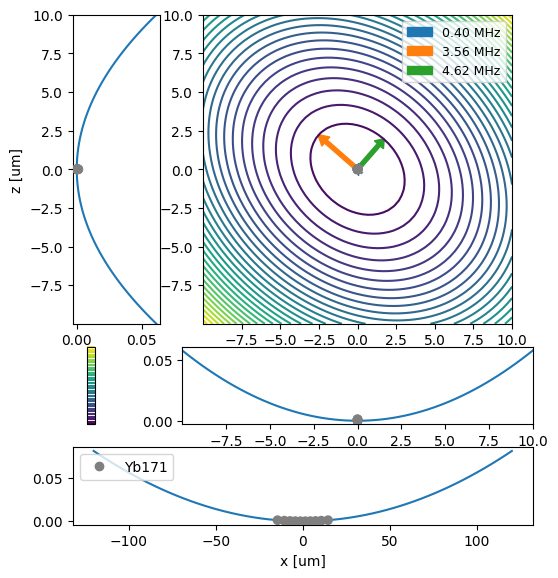

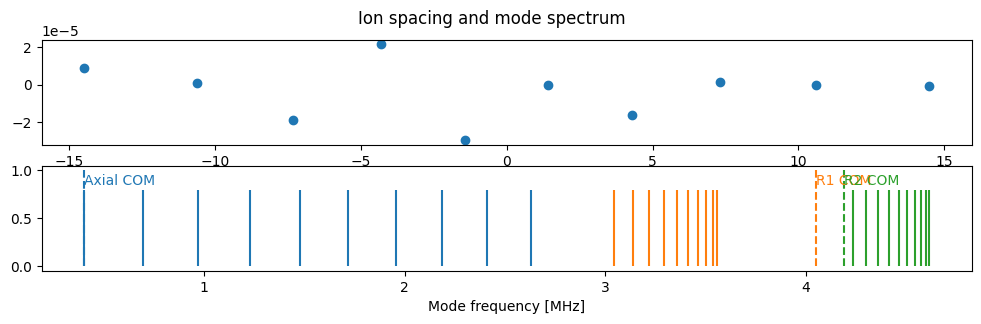

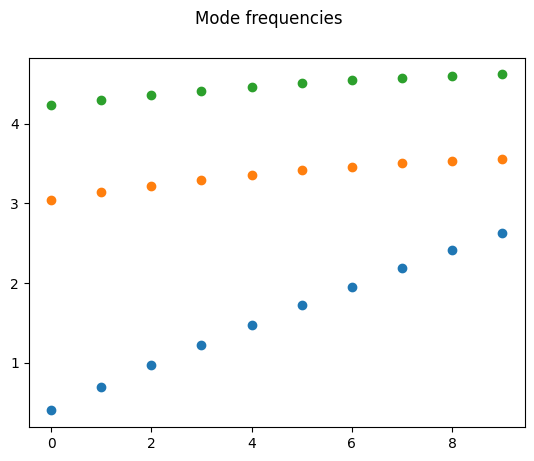

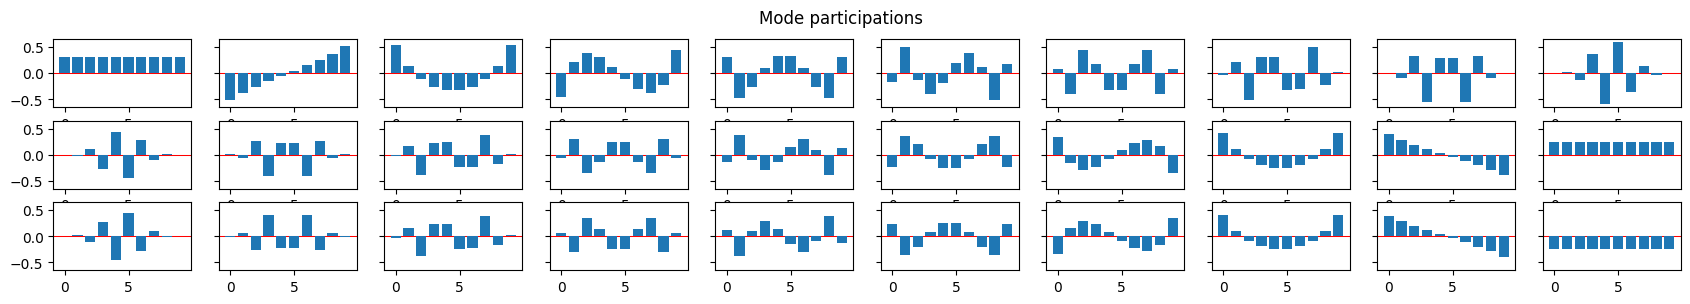

In [3]:
# wx, wy, wz = 1.3e6, 3.5e6, 4.19e6
wx, wy, wz = 0.4e6, 4.05e6, 4.19e6
trap_freqs = np.asarray([wx, wy, wz])
ion = Yb171

trap = HarmonicTrap(wx, wy, wz, ion=ion, tilt_yz=3e8)
n_ions = 10
ions = [ion] * n_ions

result = analyse_potential(trap, voltages=None, ions=ions, ion1=ions[0], r0=(0, 0, 0), roi=(120e-6, 1e-5, 1e-5), verbose=False)
# result = mode_solver(trap, voltages=None, ions=ions, x0=x0)


fig, (ax0, ax) = plt.subplots(2, 1, figsize=(12, 3), gridspec_kw=dict())
fig.suptitle("Ion spacing and mode spectrum")

mode_freqs = result.mode_solver_results.mode_freqs
mode_vectors = result.mode_solver_results.mode_vectors
x_eq = result.mode_solver_results.x_eq

ax0.plot(x_eq[:, 0] * 1e6, x_eq[:, 1] * 1e6, 'o')
# ax0.set_ylim(-0.6, 0.6)

# projections of normal modes on single-ion eigenmodes
v1 = np.eye(3)
proj = abs(np.einsum('Mai,im', mode_vectors, v1)).sum(1)
mode1_index = np.argmax(proj, axis=1)

colors = np.asarray(['k'] * len(mode_freqs), dtype=object)
for j in range(3):
    colors[np.where(mode1_index == j)] = f"C{j}"


ax.vlines(mode_freqs * 1e-6, 0, 0.8, colors=colors)
ax.vlines(trap_freqs * 1e-6, 0, 1, colors=[f"C{j}" for j in range(3)], linestyle='--')
ax.text(trap_freqs[0] * 1e-6, 0.85, 'Axial COM', color="C0")
ax.text(trap_freqs[1] * 1e-6, 0.85, 'R1 COM', color="C1")
ax.text(trap_freqs[2] * 1e-6, 0.85, 'R2 COM', color="C2")

ax0.set(
    xlabel='x [um]'
)
ax.set(
    xlabel='Mode frequency [MHz]'
)

fig, ax = plt.subplots()
fig.suptitle('Mode frequencies')
mode_labels = []
for j in range(3):
    mode_labels.append(np.where(mode1_index == j)[0])

for j in range(3):
    ax.plot(mode_freqs[mode_labels[j]] * 1e-6, 'o')

# rfreqs = [1.905, 1.985, 2.057, 2.114, 2.153]
# ax.plot(rfreqs, 'xk', ms=9)



fig, axess = plt.subplots(3, len(mode_labels[j]), figsize=(21, 3), sharey=True)
fig.suptitle(f'Mode participations')

for j, axes in enumerate(axess):
    mode_vectors_1 = mode_vectors[mode_labels[j]][:, :, j]
    for mode, ax in enumerate(axes):
        m = mode_vectors_1[mode]
        ax.bar(np.arange(len(m)), m)
        ax.axhline(0, color='r', lw=0.75, zorder=-1)


In [4]:
msr = result.mode_solver_results
H0 = msr.hess
modes = msr.mode_vectors

In [5]:

from pytrans.analysis.mode_solver import diagonalize_hessian

def subm(i1, i2=None):
    i2 = i1 if i2 is None else i2
    return (slice(i1*3, (i1+1)*3), slice(i2*3, (i2+1)*3))

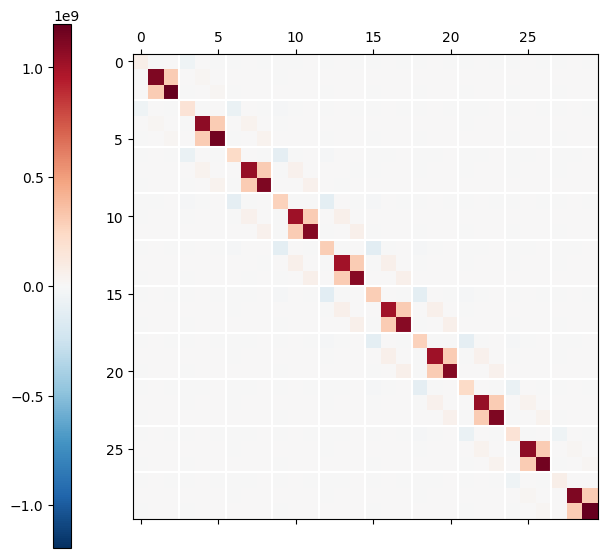

In [6]:
from matplotlib.colorbar import make_axes

def hessian_matshow(ax, M):
    c = ax.matshow(M, vmin=-M.max(), cmap='RdBu_r')
    cax, kk = make_axes(ax, location='left', shrink=0.85, aspect=30)
    plt.colorbar(c, cax=cax, **kk)
    ax.vlines(np.arange(0, len(M), 3) - 0.5, *ax.get_ylim(), color='white')
    ax.hlines(np.arange(0, len(M), 3) - 0.5, *ax.get_xlim(), color='white')


fig, ax = plt.subplots(figsize=(8, 8))
hessian_matshow(ax, H0)


In [7]:
# local basis

U = np.zeros_like(H0)

for j in range(len(H0) // 3):
    s = subm(j)
    h1 = H0[s]
    f, m = diagonalize_hessian([ion], h1)
    U[s] = np.squeeze(m).T
    
    

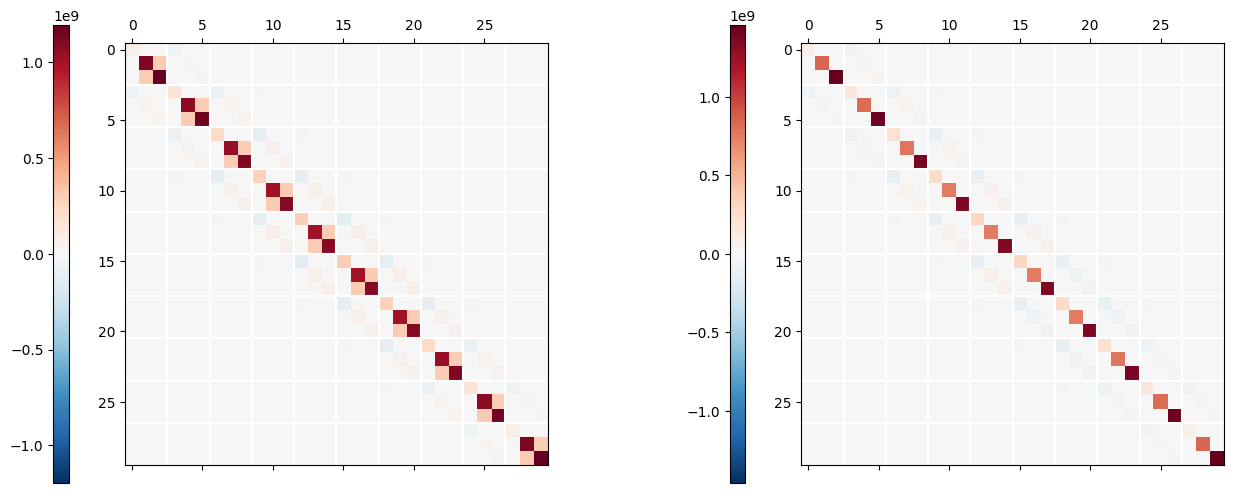

In [8]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(16, 7))
hessian_matshow(ax, H0)
H1 = U.T @ H0 @ U

hessian_matshow(ax1, H1)

In [9]:
H0[subm(3, 4)]

array([[-1.19791522e+08,  3.19045687e+03, -1.93649981e+03],
       [ 3.19045687e+03,  5.98957609e+07,  3.43837307e-02],
       [-1.93649981e+03,  3.43837307e-02,  5.98957609e+07]])

In [10]:
H1[subm(3, 4)]


array([[-1.19791522e+08,  4.20227454e+03,  6.93100521e+02],
       [ 4.05677918e+03,  5.98957608e+07, -1.25096543e-02],
       [ 7.50687024e+02, -2.07410504e-02,  5.98957609e+07]])